In [5]:
import argparse
import os
import numpy as np
import scipy.stats
from scipy.stats import wilcoxon
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
from operator import itemgetter

plt.style.use('ggplot')

from msmarco_compare import compute_metrics_from_files 

In [2]:
def load_metrics(file):
    metrics = {}
    with open(file, 'r') as f:
        for line in f:
            metric, qid, score = line.split('\t')
            metric = metric.strip()
            qid = qid.strip()
            score = score.strip()
            if qid == 'all':
                continue
            if metric not in metrics:
                metrics[metric] = {}
            metrics[metric][qid] = float(score)

    return metrics

In [3]:
def plot(all_results, ymin=-1, ymax=1, output_path="."):
    fig, ax = plt.subplots(1, 1, figsize=(16, 3))
    all_results.sort(key = itemgetter(1), reverse=True)
    x = [_x+0.5 for _x in range(len(all_results))]
    y = [float(ele[1]) for ele in all_results]
    ax.bar(x, y, width=0.6, align='edge')
    ax.set_xticks(x)
    ax.set_xticklabels([int(ele[0]) for ele in all_results], {'fontsize': 4}, rotation='vertical')
    ax.grid(True)
    ax.set_title("Per-topic analysis on {}".format(metric))
    ax.set_xlabel('Topics')
    ax.set_ylabel('{} Diff'.format(metric))
    ax.set_ylim(ymin, ymax)
    plt.show()
    #output_fn = os.path.join(output_path, 'per_query_{}.pdf'.format(metric))
    #plt.savefig(output_fn, bbox_inches='tight', format='pdf')

In [4]:
import pandas as pd

path = "G:/python/anserini/src/main/resources/topics-and-qrels/"
topics_file = "topics.dl19-doc.txt"

topics = pd.read_csv(path+topics_file,sep="\t",names=["ID","Question"])
topics["ID"]= topics["ID"].astype(str)

topics.head()

,ID,Question
0,156493,do goldfish grow
1,1110199,what is wifi vs bluetooth
2,1063750,why did the us volunterilay enter ww1
3,130510,definition declaratory judgment
4,489204,right pelvic pain causes


1037798	0.0	0.0	0.0
104861	0.0091	0.0	-0.0091
1063750	0.0076	0.0031	-0.0045
1103812	0.0292	0.0	-0.0292
1106007	0.0041	0.0	-0.0041
1110199	0.0711	0.1252	0.0541
1112341	0.0056	0.0097	0.0041
1113437	0.0067	0.0145	0.0078
1114646	0.1019	0.112	0.0101
1114819	0.0158	0.0178	0.002
1115776	0.6092	0.5901	-0.0191
1117099	0.011	0.0259	0.0149
1121402	0.1818	0.1818	0.0
1124210	0.0362	0.0362	0.0
1129237	0.0614	0.0132	-0.0482
1132213	0.3366	0.3634	0.0268
1133167	0.0503	0.0503	0.0
130510	0.2063	0.2381	0.0318
131843	0.24	0.1862	-0.0538
146187	0.177	0.185	0.008
148538	0.0257	0.0361	0.0104
156493	0.0662	0.0662	0.0
182539	0.1626	0.119	-0.0436
183378	0.0241	0.0275	0.0034
19335	0.1016	0.1635	0.0619
207786	0.085	0.0276	-0.0574
264014	0.0565	0.0565	0.0
287683	0.3278	0.425	0.0972
359349	0.0546	0.0486	-0.006
405717	0.1124	0.1369	0.0245
443396	0.0	0.0	0.0
451602	0.0059	0.0064	0.0005
47923	0.0071	0.0055	-0.0016
489204	0.0029	0.0041	0.0012
490595	0.1293	0.1723	0.043
527433	0.0683	0.0575	-0.0108
573724	0.14	0.075	-0.

<ipython-input-3-26952193c052>:8: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_xticklabels([int(ele[0]) for ele in all_results], {'fontsize': 4}, rotation='vertical')


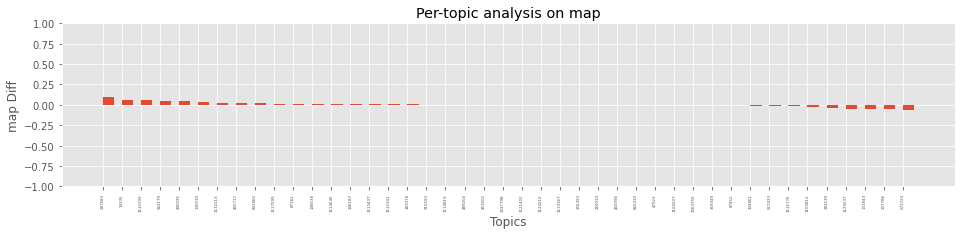

        ID                                        Question
28  287683  how many liberty ships were built in brunswick


In [6]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--base", type=str, help='base run', required=True)
# parser.add_argument("--comparison", type=str, help='comparison run', required=True)
# parser.add_argument("--qrels", type=str, help='qrels', required=True)
# parser.add_argument("--metric", type=str, help='metric', default="map")
# parser.add_argument("--msmarco", action='store_true', default=False, help='whether to use masarco eval script')
# parser.add_argument("--ymin", type=float, help='min value of the y axis', default=-1)
# parser.add_argument("--ymax", type=float, help='max value of the y axis', default=1)

#args = parser.parse_args()

base = "runs/bm25.txt"
comp = "runs/bm25+rm3.txt"
qrels = "qrels.dl19-doc.txt"
#metric = "map set_f.1 P.10 set_recall.10 ndcg"
metric = "map"
msmarco = False
ymin = -1
ymax = 1

if msmarco:
    base_all, base_metrics = compute_metrics_from_files(qrels, base, per_query_score=True) 
    comp_all, comp_metrics = compute_metrics_from_files(qrels, comp, per_query_score=True) 
else:
    os.system(f'G:/python/ir/eval/trec_eval.9.0.4/trec_eval -q -M1000 -m {metric} {qrels} {base} > eval.base')
    os.system(f'G:/python/ir/eval/trec_eval.9.0.4/trec_eval -q -M1000 -m {metric} {qrels} {comp} > eval.comp')

    base_metrics = load_metrics('eval.base')
    comp_metrics = load_metrics('eval.comp')

# trec_eval expects something like 'P.10' on the command line but outputs 'P_10'
if "." in metric:
    metric = "_".join(metric.split("."))

all_results = []
num_better = 0
num_worse = 0
num_unchanged = 0
biggest_gain = 0
biggest_gain_topic = ''
biggest_loss = 0
biggest_loss_topic = ''
if msmarco:
    metric = "MRR@10"
keys = []
for key in base_metrics[metric]:
    base_score = base_metrics[metric][key]
    if key not in comp_metrics[metric]:
        continue
    keys.append(key)
    comp_score = comp_metrics[metric][key]
    diff = comp_score - base_score
    # This is our relatively arbitrary definition of "better", "worse", and "unchanged".
    if diff > 0.01:
        num_better += 1
    elif diff < -0.01:
        num_worse += 1
    else:
        num_unchanged += 1
    if diff > biggest_gain:
        biggest_gain = diff
        biggest_gain_topic = key
    if diff < biggest_loss:
        biggest_loss = diff
        biggest_loss_topic = key
    all_results.append((key, diff))
    print(f'{key}\t{base_score:.4}\t{comp_score:.4}\t{diff:.4}')

# Extract the paired scores
a = [base_metrics[metric][k] for k in keys]
b = [comp_metrics[metric][k] for k in keys]

(tstat, pvalue) = scipy.stats.ttest_rel(a, b)
w, p = wilcoxon(a,b)
print(f'base mean: {np.mean(a):.4}')
print(f'comp mean: {np.mean(b):.4}')
print(f't-statistic: {tstat:.6}, p-value: {pvalue:.6}')
print(f'wilcoxon: w: {w}, p: {p}')
print(f'better (diff > 0.01): {num_better:>3}')
print(f'worse  (diff > 0.01): {num_worse:>3}')
print(f'(mostly) unchanged  : {num_unchanged:>3}')
print(f'biggest gain: {float(biggest_gain):.4} (topic {biggest_gain_topic})')
print(f'biggest loss: {float(biggest_loss):.4} (topic {biggest_loss_topic})')

plot(all_results, ymin=ymin, ymax=ymax)

print(topics.loc[topics['ID'] == biggest_gain_topic])